In [1]:
import random
from env import TicTacToeEnv, agent_by_mark, check_game_status, after_action_state, tomark, next_mark
import numpy as np
import random
import matplotlib.pylab as plt

# Tree definition

In [2]:
import weakref
class TreeNode(object):
    _instances = set()
    def __init__(self, data, parent=None):
        self.data = data
        self.children = []
        self.parent = parent
        self._instances.add(weakref.ref(self))

    def add_child(self, obj):
        self.children.append(obj)
        obj.parent = self
    
    def print(self):
        env1 = TicTacToeEnv()
        env1.set_start_mark('X') # start_mark
        intial_state = env1.set_to_state(to_state=self.data['state'])
        env1.render()
        
    @classmethod
    def getinstances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead

class Tree:
    def __init__(self):
        self.root = TreeNode({'state':"ROOT"})   

In [3]:
def get_leaves(node):
    if not node.children:
        yield node

    for child in node.children:
        for leaf in get_leaves(child):
             yield leaf

# Minmax without sampling

## Building Tree 

In [4]:
def travarse_tree(current_node, done):
    
    if not done and current_node.data['ava_actions']:
        action = current_node.data['ava_actions'][0]
        state = env.set_to_state(current_node.data['state'])
            
        new_state, reward, done, info = env.step(action) # take action
        current_node.data['ava_actions'].remove(action) # removing the action taken from memory

        new_node_data = {}
        new_node_data['state'] = new_state
        new_node_data['level'] = current_node.data['level'] + 1 # increase to new level
        new_node_data['ava_actions'] = env.available_actions() # available actions in new state
        new_node_data['reward'] = reward  # reward obtained in reaching the new state
        new_node_data['action'] = action  # action that has brought to new state
        new_node_data['mms_values'] = {}
        new_node_data['pr_values'] = {}
        new_node_data['mms_progress'] = {}
        new_node_data['pr_progress'] = {}
        if done:
            new_node_data['mm_value'] = reward
        else:
            new_node_data['mm_value'] = None
        new_node = TreeNode(new_node_data)
        current_node.add_child(new_node)  # saving new state values in the new node
        current_node = new_node
        return travarse_tree(current_node, done) # go to next step
        
    elif current_node.data['action'] != None: # check for reaching root node
        current_node = current_node.parent
        done = False
        return travarse_tree(current_node, done)

In [5]:
# build_full_tree

env = TicTacToeEnv()
env.set_start_mark('X') # start_mark
# state = env.set_to_state(to_state=((0,2,0,1,1,0,0,2,0),'X'))
state = env.set_to_state()
ava_actions = env.available_actions()

tree = Tree()
root_node = current_node = tree.root
current_node.data['reward'] = 0
current_node.data['action'] = None # action that has brought to new state
current_node.data['ava_actions'] = ava_actions
current_node.data['level'] = 0
current_node.data['state'] = state
current_node.data['mm_value'] = None
current_node.data['mms_values'] = {}
current_node.data['pr_values'] = {}
current_node.data['mms_progress'] = {}
current_node.data['pr_progress'] = {}
done = False

travarse_tree(current_node, done)

In [6]:
len(list(get_leaves(root_node)))

102

## Model

In [7]:
leaf_nodes = list(get_leaves(root_node))
current_node = list(get_leaves(root_node))[0]

def minimax_without_sampling(current_node):
    
    if current_node in leaf_nodes:
        parent_node = current_node.parent
        return minimax_without_sampling(parent_node)
    
    else:  # compare values of children and update current node value
        children = current_node.children
        none_value_children = [child for child in children if (child.data['mm_value']==None)]
        if none_value_children:
            return minimax_without_sampling(none_value_children[0])
        else:  
            children_values = [child.data['mm_value'] for child in children]
            if current_node.data['state'][1] == 'X':
                opti_action_idx = np.argmax(children_values)          
            else:
                opti_action_idx =  np.argmin(children_values)
            current_node.data['mm_value'] = children_values[opti_action_idx]
            current_node.data['mm_opti_action'] = children[opti_action_idx].data['action']

            if current_node.data['action'] == None:  # check for reaching root node
                print(current_node.data)
            else:
                parent_node = current_node.parent  # after comparision go to parent node
                return minimax_without_sampling(parent_node)

## Results

In [8]:
leaf_nodes = list(get_leaves(root_node))
current_node = list(get_leaves(root_node))[0]

minimax_without_sampling(current_node)

{'state': ((0, 2, 0, 1, 1, 2, 0, 0, 0), 'X'), 'reward': 0, 'action': None, 'ava_actions': [], 'level': 0, 'mm_value': 1, 'mms_values': {}, 'pr_values': {}, 'mms_progress': {}, 'pr_progress': {}, 'mm_opti_action': 0}


In [9]:
root_node.print()

   |O| 
  -----
  X|X|O
  -----
   | | 



In [10]:
# supposing that both p1 and p2 play optimally
for first_move in root_node.children:
    if first_move.data['mm_value'] == 1:
        result = "winning (p1) game"
    elif first_move.data['mm_value'] == 0:
        result = "draw game"
    else:
        result = "loosing (p1) game"
    print("Action ", first_move.data['action'], "leads to a ", result, " with 100% probability")

Action  0 leads to a  winning (p1) game  with 100% probability
Action  2 leads to a  draw game  with 100% probability
Action  6 leads to a  winning (p1) game  with 100% probability
Action  7 leads to a  loosing (p1) game  with 100% probability
Action  8 leads to a  draw game  with 100% probability


In [14]:
# supposing both players play randomly
for first_move in root_node.children:
    leaves_form_this_move = list(get_leaves(first_move))
    winning_leaves = [leaf for leaf in leaves_form_this_move if leaf.data['mm_value']==1]
    prob_percent = (len(winning_leaves)/len(leaves_form_this_move))*100
    print("Action ", first_move.data['action'], "leads to a winning (p1) game", f" with {prob_percent}% probability")

Action  0 leads to a winning (p1) game  with 66.66666666666666% probability
Action  2 leads to a winning (p1) game  with 61.904761904761905% probability
Action  6 leads to a winning (p1) game  with 66.66666666666666% probability
Action  7 leads to a winning (p1) game  with 33.33333333333333% probability
Action  8 leads to a winning (p1) game  with 61.904761904761905% probability


In [15]:
# supposing both players play randomly
for first_move in root_node.children:
    leaves_form_this_move = list(get_leaves(first_move))
    winning_leaves = [leaf for leaf in leaves_form_this_move if leaf.data['mm_value']==0]
    prob_percent = (len(winning_leaves)/len(leaves_form_this_move))*100
    print("Action ", first_move.data['action'], "leads to a draw game", f" with {prob_percent}% probability")

Action  0 leads to a draw game  with 22.22222222222222% probability
Action  2 leads to a draw game  with 38.095238095238095% probability
Action  6 leads to a draw game  with 0.0% probability
Action  7 leads to a draw game  with 33.33333333333333% probability
Action  8 leads to a draw game  with 19.047619047619047% probability


In [16]:
# supposing both players play randomly
for first_move in root_node.children:
    leaves_form_this_move = list(get_leaves(first_move))
    winning_leaves = [leaf for leaf in leaves_form_this_move if leaf.data['mm_value']==-1]
    prob_percent = (len(winning_leaves)/len(leaves_form_this_move))*100
    print("Action ", first_move.data['action'], "leads to a loosing (p1) game", f" with {prob_percent}% probability")

Action  0 leads to a loosing (p1) game  with 11.11111111111111% probability
Action  2 leads to a loosing (p1) game  with 0.0% probability
Action  6 leads to a loosing (p1) game  with 33.33333333333333% probability
Action  7 leads to a loosing (p1) game  with 33.33333333333333% probability
Action  8 leads to a loosing (p1) game  with 19.047619047619047% probability


# Minmax with sampling

## Sampling

In [18]:
def get_trajectory(node, trajectory):
    if node!=root_node:
        trajectory.append(node)
        return get_trajectory(node.parent, trajectory)
    else:
        return trajectory

In [19]:
def generate_sampled_tree(n_samples):
    # list of nodes from root to leaf
    leaves = random.choices(list(get_leaves(root_node)), k=n_samples)
    sampled_tree = {}
    for i, leaf in enumerate(leaves):
        trajectory = get_trajectory(leaf, [])
        for node in trajectory:
            if node in sampled_tree:
                sampled_tree[node] += 1
            else:
                sampled_tree[node] = 1
    return sampled_tree

## Model

In [20]:
def minimax_with_sampling(current_node, sampled_tree, i, leaf_nodes):
    if current_node in leaf_nodes:
        current_node.data['mms_values'][i] = current_node.data['reward']
        parent_node = current_node.parent
        return minimax_with_sampling(parent_node, sampled_tree, i, leaf_nodes)
    
    else:  # compare values of children and update current node value
        children = [child for child in current_node.children if (child in sampled_tree)]
        none_value_children = [child for child in children if (i not in child.data['mms_values'])]
        if none_value_children:
            return minimax_with_sampling(none_value_children[0], sampled_tree, i, leaf_nodes)
        else:  
            children_values = [child.data['mms_values'][i] for child in children]
            if current_node.data['state'][1] == 'X':
                opti_action_idx = np.argmax(children_values)          
            else:
                opti_action_idx =  np.argmin(children_values)
            current_node.data['mms_values'][i] = children_values[opti_action_idx]

            if current_node.data['action'] != None:  # check for reaching root node
                parent_node = current_node.parent  # after comparision go to parent node
                return minimax_with_sampling(parent_node, sampled_tree, i, leaf_nodes)                

## Results

In [21]:
n_simulations = 1000
n_sampled_trajectories = 400
for i in range(n_simulations):
    sampled_tree = generate_sampled_tree(n_samples=n_sampled_trajectories)
    leaf_nodes = [node for node in list(get_leaves(root_node)) if node in sampled_tree]
    minimax_with_sampling(leaf_nodes[0], sampled_tree, i, leaf_nodes)

In [24]:
leaf_nodes = list(get_leaves(root_node))
# for node in root_node.children:
for node in TreeNode.getinstances():
    for i in node.data['mms_values'].keys():
        mms_progress_value = 0
        count = 0
        for sim_n in node.data['mms_values'].keys():
            if sim_n <= i:
                count += 1
                mms_progress_value += node.data['mms_values'][sim_n]
#         if n_sampled_trajectories < len(leaf_nodes):
#             count = (count*n_sampled_trajectories)/len(leaf_nodes)  #normalizing
        node.data['mms_progress'][i]= mms_progress_value/count

In [25]:
for node in root_node.children:
# for node in TreeNode.getinstances():
    if node not in leaf_nodes:
        children = [child for child in node.children if (child.data['mms_progress'])]
        children_values = [child.data['mms_progress'][max(child.data['mms_progress'].keys())] for child in children]
        opti_action_idx = np.argmax(children_values)                                           
        node.data['mms_opti_action'] = children[opti_action_idx].data['action']

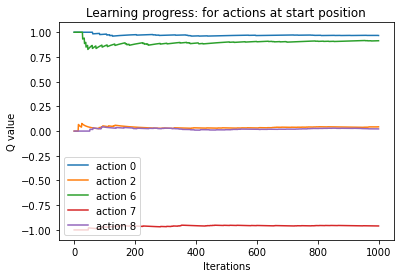

In [26]:
for node in root_node.children:
    lists = sorted(node.data['mms_progress'].items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x,y, label=f"action {node.data['action']}")
plt.title('Learning progress: for actions at start position')
plt.xlabel('Iterations')
plt.ylabel('Q value') 
plt.legend()
plt.show()

In [42]:
# supposing both players play optimally

mapping = {
    0: {},
    2: {},
    6: {},
    7: {},
    8: {},
}

for first_move in root_node.children:
    for i in first_move.data['mms_values'].keys():
        win_count = 0
        count = 0
        for sim_n in first_move.data['mms_values'].keys():
            if sim_n <= i:
                count += 1
                if first_move.data['mms_values'][sim_n]==1:
                    win_count += 1
        mapping[first_move.data['action']][i] = float(win_count/count)
    print("Action ", first_move.data['action']," leads to a winning (p1) game with ",
          mapping[first_move.data['action']][i], "% probability")

Action  0  leads to a winning (p1) game with  0.968 % probability
Action  2  leads to a winning (p1) game with  0.043 % probability
Action  6  leads to a winning (p1) game with  0.957 % probability
Action  7  leads to a winning (p1) game with  0.0 % probability
Action  8  leads to a winning (p1) game with  0.037 % probability


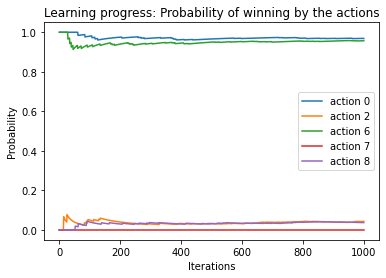

In [44]:
for key, dict_ in mapping.items():
    plt.plot(*zip(*sorted(dict_.items())), label=f"action {key}")

plt.title('Learning progress: Probability of winning by the actions')
plt.xlabel('Iterations')
plt.ylabel('Probability') 
plt.legend()
plt.show()